In [544]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from itertools import chain

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, InputLayer
from keras.optimizers import Adam

In [545]:
training_length = 20
test_size = 0.1
batch_size = 16
epochs = 500

# Load dataset

In [546]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
covid = pd.read_csv('covid-data.csv', parse_dates=['date'], date_parser=dateparse)
min_date = covid.date.min()
covid = covid[covid.iso_code == 'TUR']
covid = covid.set_index('date')

# Remove all `NaN` columns

In [547]:
numeric_cols = covid.notna().any()
covid = covid.loc[:, numeric_cols]

# Remove all same columns

In [548]:
num_unique = covid.nunique()
covid = covid.loc[:, num_unique > 1]

In [549]:
cols = list(covid.columns)
def get_col(col):
    return cols.index(col)
cols

['total_cases',
 'new_cases',
 'total_deaths',
 'new_deaths',
 'total_cases_per_million',
 'new_cases_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'total_tests',
 'new_tests',
 'total_tests_per_thousand',
 'new_tests_per_thousand']

# Fill missing values

In [550]:
covid.fillna(0, inplace=True)

In [551]:
idx = pd.date_range(covid.index.min(), covid.index.max())
covid = covid.reindex(idx)
covid.fillna(-1, inplace=True) # filling missing date values with -1
# idx = pd.date_range(min_date, covid.index.max())
# covid = covid.reindex(idx, fill_value=0)

# Scale the data

In [552]:
scaler = StandardScaler()
covid = scaler.fit_transform(covid)

# Extract train and test data

In [553]:
X, y = [], []
for i in range(training_length, covid.shape[0]):
    sample = covid[i - training_length:i + 1]
    X.append(sample[:-1])
    y.append(sample[-1])
X = np.array(X)
y = np.array(y)

In [554]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)#, shuffle=False)
# shuffled_indices = np.arange(X_train.shape[0])
# np.random.shuffle(shuffled_indices)
# X_train = X_train[shuffled_indices]
# y_train = y_train[shuffled_indices]
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)

X_train.shape: (35, 20, 12)
y_train.shape: (35, 12)
X_test.shape: (4, 20, 12)
y_test.shape: (4, 12)


# Create and train the model

In [555]:
model = Sequential()

model.add(InputLayer(input_shape=X_train.shape[1:]))
model.add(Dense(128, activation='relu'))
model.add(LSTM(128, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(X_train.shape[-1]))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

In [556]:
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
#                     validation_split=0.2,
                    verbose=False).history

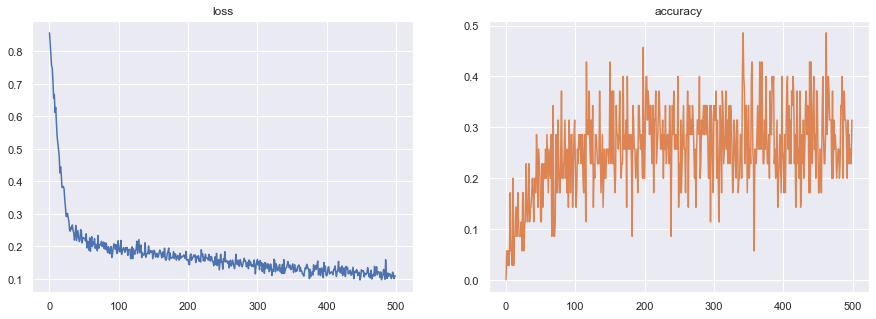

In [557]:
keys = list(history.keys())
if len(keys) == 4:
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for key, ax in zip(keys, chain.from_iterable(axs)):
        ax.set_title(key)
        ax.plot(history[key], color='C0' if 'loss' in key else 'C1')
elif len(keys) == 2:
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for key, ax in zip(keys, axs):
        ax.set_title(key)
        ax.plot(history[key], color='C0' if 'loss' in key else 'C1')
plt.show()

# Test the model

In [558]:
def get_next(days=10, col='total_cases'):
    data = covid[-training_length:]
    y_pred = []
    for _ in range(days):
        y_pred.append(model.predict(data[None])[0])
        data = np.vstack((data[1:], y_pred[-1]))
    y_pred = np.array(y_pred)
    return scaler.inverse_transform(y_pred)[:, get_col(col)].tolist()

In [559]:
def plot_next(days=10, col='total_cases'):
    plt.figure(figsize=(13, 6))
    plt.title(f"Next {days} days of {' '.join(col.split('_'))} from the dashed line to the right", fontsize=14)
    old = scaler.inverse_transform(covid)[:, get_col(col)].tolist()
    plt.axvline(len(old), color='r', dashes=[5, 5], alpha=0.7)
    # old = []
    old.extend(get_next(days, col))
    plt.plot(old)
    plt.show()

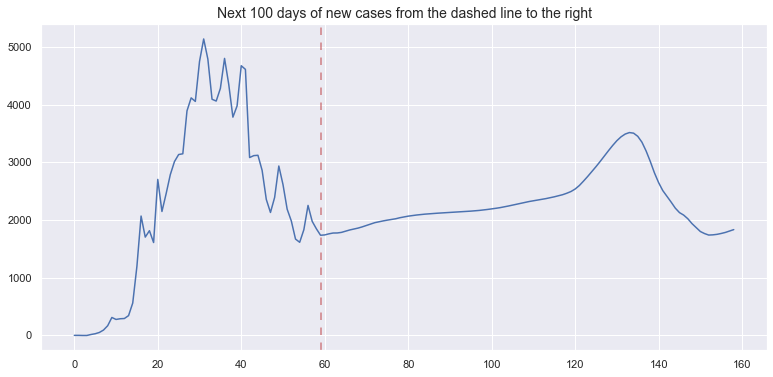

In [560]:
plot_next(100, 'new_cases')